# Create multliayer Food groups 
It is a copy of Multilayer food_groups.ipynb but that I am going to mess-up to tranform into a code that I can apply to make trajectories of a country across the years

In [3]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 
import pickle
import plotly.express as px

In [4]:
def Edge_overlap_w(data,weight):
    """Calculate the weighted edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """
    if weight==True:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : group.value.sum())
    else:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : len(group))

    overlap_w= pd.DataFrame(overlap_w.sort_values(ascending=False),columns=['o_i'])
    return overlap_w

def Node_strength(data, weight = True):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """
    
    if (weight==True):
        str_i_l = data.groupby([group_class,'unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    else:
        str_i_l = data.groupby([group_class,'unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc=lambda x: len(x.unique())).
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Participation_coeff_old (data,overlap):

    #Define elements for part_coeff
    L = len(data[group_class].unique())

    
    s_i_l = Node_strength_w(data)

    # Prepare data
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country','overl']], left_on= 'origin_country_ISO',right_on='country', how='left')


    # Contibution of each layer to total exports
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc['overl'])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff =  pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['partic_coeff']).sort_values(by='partic_coeff',ascending=False)
    return particip_coeff 
  
def Participation_coeff (data, overlap, direction, weight=True):

    if (weight == True):
        w_f = '_w'
        flag_overlap = 'overl'
    else:
        w_f = ''
        flag_overlap = 'deg'

    #Define elements for part_coeff
    L = len(data[group_class].unique())
    
    s_i_l = Node_strength(data,weight)

    # Prepare data
    #data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country',direction+'_'+flag_overlap]], left_on= 'origin_country_ISO',right_on='country', how='left')

    # Contibution of each layer to total exports:
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc[direction+'_'+flag_overlap])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff = (pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['pc'+w_f+'_'+direction]).
                      sort_values(by='pc'+w_f+'_'+direction,ascending=False))
    return particip_coeff 


def Agregated_network (edge_data,node_info, group_class):
    
    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data[group_class]), edge_data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        

def Make_dict_years (data_in, year_check):
    """ 
    Iterate everything to filter data per year, get network and network stats. 
    The output should be a the dataframe with the value of overlap and zscore for each country the year being explored. 

    This will be saved in a dictionary. 
    """
    print(year_check)
    # Load data 
    data_filt = data_in.loc[(data_in.unit =='1000 US$') & (data_in.year == year_check) & (data_in.value > 0) ,:].copy()

    # Create agregated multilayer network 
    G = Agregated_network(data_filt, country_metadata, group_class = group_class)

    # Degree estimations
    out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
    in_degree= pd.DataFrame([i for i in G.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

    # Overlap: sum of weights (out_degree)
    overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
    in_overlap= pd.DataFrame([i for i in G.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

    overlap= pd.merge(overlap,in_overlap, on='country', copy=False)
    overlap= pd.merge(overlap,out_degree, on='country', copy=False)
    overlap= pd.merge(overlap,in_degree, on='country', copy=False)

    # Add z score degree and overlap:
    overlap['z_'+direction+'_deg'] = (overlap[direction+'_deg'] - overlap[direction+'_deg'].mean())/overlap[direction+'_deg'].std()

    overlap['z_'+direction+'_overl'] = (overlap[direction+'_overl'] - overlap[direction+'_overl'].mean()) / overlap[direction+'_overl'].std()

    # Participation coefficient: 
    partic_coeff = Participation_coeff(data_filt, overlap, direction,weight=False)
    partic_coeff_w = Participation_coeff(data_filt, overlap, direction,weight=True)
    partic_coeff = pd.merge(partic_coeff, partic_coeff_w, left_index=True, right_index=True,how='left')

    # Merge participation and degree dataframes:
    deg_particip = pd.merge(overlap, partic_coeff, right_index=True, left_on='country',how='left')
    # deg_particip = pd.merge(deg_particip, partic_coeff_w, left_on='country',right_index=True,how='left',copy=False)
    return deg_particip
'''
def Country_map (dict_results,country, axis):

    year_list = list(dict_results.keys())
    print(year_list)
    coords = pd.DataFrame()
    for y in year_list:
        to_add= dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] 
        coords = pd.concat([coords,to_add])
    coords.index = year_list

    # Plot 
    #axis.scatter(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
    axis.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
    axis.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')
    axis.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'red')
    axis.set_ylim(bottom=0)
    plt.show()
    return coords
'''

"\ndef Country_map (dict_results,country, axis):\n\n    year_list = list(dict_results.keys())\n    print(year_list)\n    coords = pd.DataFrame()\n    for y in year_list:\n        to_add= dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] \n        coords = pd.concat([coords,to_add])\n    coords.index = year_list\n\n    # Plot \n    #axis.scatter(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)\n    axis.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)\n    axis.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')\n    axis.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'red')\n    axis.set_ylim(bottom=0)\n    plt.show()\n    return coords\n"

In [5]:
year_check= 2019 #'1986-1988'#2019
direction = 'out'
group_class = 'Food_group' # item
#data_og = pd.read_pickle('../Data/Data_year_groups_12.pkl')

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

data_og = pd.read_pickle('../Data/Data_food_groups.pkl')


In [6]:
data_og

,index,destin_country_ISO,origin_country_ISO,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,14235148,KW,IT,1986,tonnes,1.0,Italy,Kuwait,A04PE,Confectionery including chocolate
1,14235170,KW,IT,1986,1000 US$,30.0,Italy,Kuwait,A04PE,Confectionery including chocolate
2,14235436,KW,SG,1986,tonnes,17.0,Singapore,Kuwait,A04PE,Confectionery including chocolate
3,14235456,KW,SG,1986,1000 US$,27.0,Singapore,Kuwait,A04PE,Confectionery including chocolate
4,14236866,BN,CN,1986,tonnes,8.0,"China, mainland",Brunei Darussalam,A04PE,Confectionery including chocolate
...,...,...,...,...,...,...,...,...,...,...
6846474,21929008,SZ,CH,2021,1000 US$,4.0,Switzerland,Eswatini,A03DJ,Water and water-based beverages
6846475,21929020,SZ,AT,2021,tonnes,3.0,Austria,Eswatini,A03DJ,Water and water-based beverages
6846476,21929026,SZ,AT,2021,1000 US$,3.0,Austria,Eswatini,A03DJ,Water and water-based beverages
6846477,21929047,SZ,MZ,2021,tonnes,0.0,Mozambique,Eswatini,A03DJ,Water and water-based beverages


Iterate estimation for all countries and years. It is saved as a dictionary with a single pandas datafarame containing all outputs. 

In [13]:
list_years = data_og.year.unique()

dict_results = dict()
for i in list_years: 
    dict_aux = Make_dict_years(data_og,i)
    dict_results[i] = dict_aux.copy()

dict_results = dict((i, Make_dict_years(data_og,i)) for i in list_years)
dict_results

pickle.dump(dict_results, open('../Data/country_overlap_particip.pkl', 'wb'))


1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


In [8]:
coords =dict_results[2019]
coords.loc[(coords.pc_w_out>=2/3) & (coords.z_out_overl>=2),:]


,country,out_overl,in_overl,out_deg,in_deg,z_out_deg,z_out_overl,pc_out,pc_w_out
0,US,114432918.0,127840425.0,2655,1930,2.983411,7.480213,1.001117,0.884688
1,NL,75675721.0,56760949.0,2846,1692,3.257692,4.810011,1.001990,0.961507
2,DE,68051285.0,79655080.0,2715,1696,3.069573,4.284721,1.003070,0.944624
3,BR,68007960.0,8169069.0,2009,773,2.055739,4.281736,1.003023,0.794436
4,FR,63222544.0,48049088.0,2826,1664,3.228971,3.952041,1.004476,0.912007
5,CN,48014871.0,117328927.0,2524,1432,2.795292,2.904299,1.002379,0.897198
6,ES,47350476.0,28510410.0,2624,1396,2.938894,2.858525,1.005130,0.920504
7,IT,43241733.0,36411652.0,2676,1398,3.013568,2.575451,1.003900,0.944354
8,CA,41658372.0,31801532.0,1691,1667,1.599083,2.466364,1.002867,0.890924
9,MX,40057771.0,22875018.0,1285,728,1.016057,2.356090,0.991736,0.898905


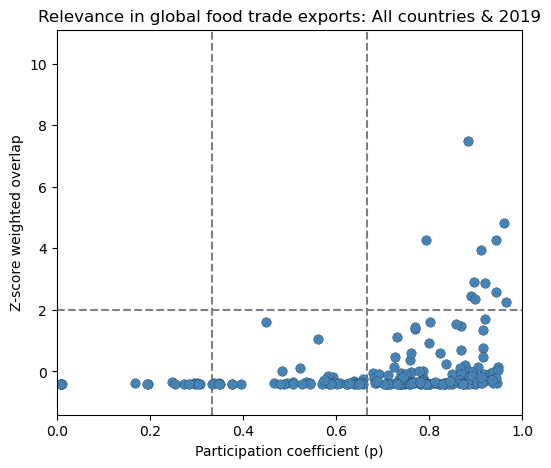

GS


,country,out_overl,in_overl,out_deg,in_deg,z_out_deg,z_out_overl,pc_out,pc_w_out
0,US,114432918.0,127840425.0,2655,1930,2.983411,7.480213,1.001117,0.884688
1,NL,75675721.0,56760949.0,2846,1692,3.257692,4.810011,1.001990,0.961507
2,DE,68051285.0,79655080.0,2715,1696,3.069573,4.284721,1.003070,0.944624
3,BR,68007960.0,8169069.0,2009,773,2.055739,4.281736,1.003023,0.794436
4,FR,63222544.0,48049088.0,2826,1664,3.228971,3.952041,1.004476,0.912007
5,CN,48014871.0,117328927.0,2524,1432,2.795292,2.904299,1.002379,0.897198
6,ES,47350476.0,28510410.0,2624,1396,2.938894,2.858525,1.005130,0.920504
7,IT,43241733.0,36411652.0,2676,1398,3.013568,2.575451,1.003900,0.944354
8,CA,41658372.0,31801532.0,1691,1667,1.599083,2.466364,1.002867,0.890924
9,MX,40057771.0,22875018.0,1285,728,1.016057,2.356090,0.991736,0.898905


In [12]:
# need to do dynamic
def Country_map_static (dict_results, country_list, year_list= 'All', plt_flag=True):

    # Define start for All flags
    if country_list == 'All':
        country_list = list(dict_results[list(dict_results.keys())[0]].country)
        title_country = 'All countries'
    else: 
        title_country  = country_list
    
    if year_list == 'All':
        year_list = list(dict_results.keys())
        title_year  = 'All years'

    else: 
        title_year  = year_list[0]

    # Define figure characteristics 
    if plt_flag == True :
        maxY_plot = max([max(dict_results[y].z_out_overl) for y in list_years])
        minY_plot = min([min(dict_results[y].z_out_overl) for y in list_years])

        fig_phase, ax = plt.subplots(figsize = (6,5))
        ax.axvline(x=1/3, color='grey', linestyle= '--', zorder =1)
        ax.axvline(x=2/3, color='grey', linestyle= '--', zorder = 1)
        ax.axhline(y=2, color='grey', linestyle= '--', zorder = 1)
        ax.set_xlim (0,1)
        ax.set_xlim (0,1)
        ax.set_ylim((minY_plot-1,maxY_plot+1))

        #
        ax.set_ylabel('Z-score weighted overlap')
        ax.set_xlabel('Participation coefficient (p)')
        #ax.set_title ('Map with weighted overlap: '+ str(title_country) +' countries' +' & '+ str(title_year))
        ax.set_title ('Relevance in global food trade exports: '+ str(title_country) +' & '+ str(title_year))

    # Iterate for countries:
    coords_dict = dict()

    for country in country_list:
        coords = pd.DataFrame()
        for y in year_list:
            to_add = dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] 
            coords = pd.concat([coords,to_add])
        coords.index = year_list

        coords_dict[country] = coords
        if (plt_flag ==True):
            # Plot 
            ax.scatter(coords.pc_w_out.iloc[2:-2], coords.z_out_overl.iloc[2:-2],zorder = 2,s=20,label= coords.index)
            ax.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
            ax.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')
            ax.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'steelblue')
            #ax.annotate(country,(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1]),zorder = 2,label= coords.index[-1],color = 'steelblue')


    fig_phase.savefig('../Plots/map_countries_export.pdf',format ='pdf',dpi=300)   
    plt.show()
    print(country)
    return coords_dict


# Coords dict 
coords_dict = Country_map_static(dict_results,country_list='All',year_list=[2019], plt_flag = True)

coords =dict_results[2019]
coords.loc[(coords.pc_w_out>=2/3) & (coords.z_out_overl>=2),:]

#pickle.dump(coords_dict, open('../Data/country_coords.pkl', 'wb'))
